# Topic modeling

In [1]:
from pprint import pprint
from tqdm.auto import tqdm

import gensim

import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
stop_words = stopwords.words('russian') + ['этот', 'свой', 'наш', 'ваш', 'весь']

In [3]:
FILE = 'whole_corpus.txt'

with open(FILE) as f:
    corpus = f.read()[:1000000]

data_ready = [
    [
        word.lower()
        for word in word_tokenize(sent)
        if word.isalpha() and word not in stop_words
    ]
    for sent in sent_tokenize(corpus)
]

Создаем словарь, который переводит слова в индексы

In [4]:
id2word = gensim.corpora.Dictionary(data_ready)

Кодируем корпус в удобном для модели виде (в виде индексов слов)

In [5]:
corpus = [id2word.doc2bow(text) for text in data_ready]

Строим тематическую модель с оптимальным количеством тем и печатаем коэффициенты слов, которые описывают распределение слов в теме (насколько характерно это слово для темы)

In [6]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,  # передаем наш корпус
    id2word=id2word,  # эта штука отвечает за соответствие слов и индексов
    num_topics=6,  # количество тем, которые мы хотим выделить
    random_state=100,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

pprint(lda_model.print_topics())

[(0,
  '0.100*"андрей" + 0.017*"каждый" + 0.015*"старик" + 0.014*"глаз" + '
  '0.013*"рука" + 0.012*"солнце" + 0.011*"гость" + 0.011*"комсомолец" + '
  '0.011*"далеко" + 0.010*"казаться"'),
 (1,
  '0.032*"человек" + 0.029*"мочь" + 0.022*"жизнь" + 0.019*"новый" + '
  '0.016*"мысль" + 0.014*"голова" + 0.013*"отвечать" + 0.013*"свободный" + '
  '0.012*"самый" + 0.012*"игра"'),
 (2,
  '0.024*"движение" + 0.020*"понимать" + 0.016*"день" + 0.014*"оставаться" + '
  '0.012*"всякий" + 0.012*"узнавать" + 0.011*"язык" + 0.011*"спрашивать" + '
  '0.011*"пора" + 0.010*"минута"'),
 (3,
  '0.033*"планета" + 0.028*"год" + 0.025*"рирэ" + 0.023*"луна" + 0.014*"ось" + '
  '0.013*"последний" + 0.013*"воздух" + 0.013*"сосиаль" + 0.013*"пьеса" + '
  '0.012*"конец"'),
 (4,
  '0.054*"это" + 0.045*"становиться" + 0.031*"время" + 0.016*"сказать" + '
  '0.015*"друг" + 0.012*"мало" + 0.012*"кислород" + 0.011*"труба" + '
  '0.011*"хотеть" + 0.011*"ничто"'),
 (5,
  '0.066*"земля" + 0.027*"который" + 0.018*"земной" 

### Визуализируем

Готовим список цветов, чтобы облака слов были разного цвета, задаем параметры для облака слов (пока без передачи туда самих слов,которые будут разными для каждой темы

In [7]:
cols = [color for name, color in matplotlib.colors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=25,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

Строим графики:

1. Задаем схему расположения графиков - сетка n*m элементов

2. Добавляем туда облака слов, заполненные словами исходя из коэффициентов для темы

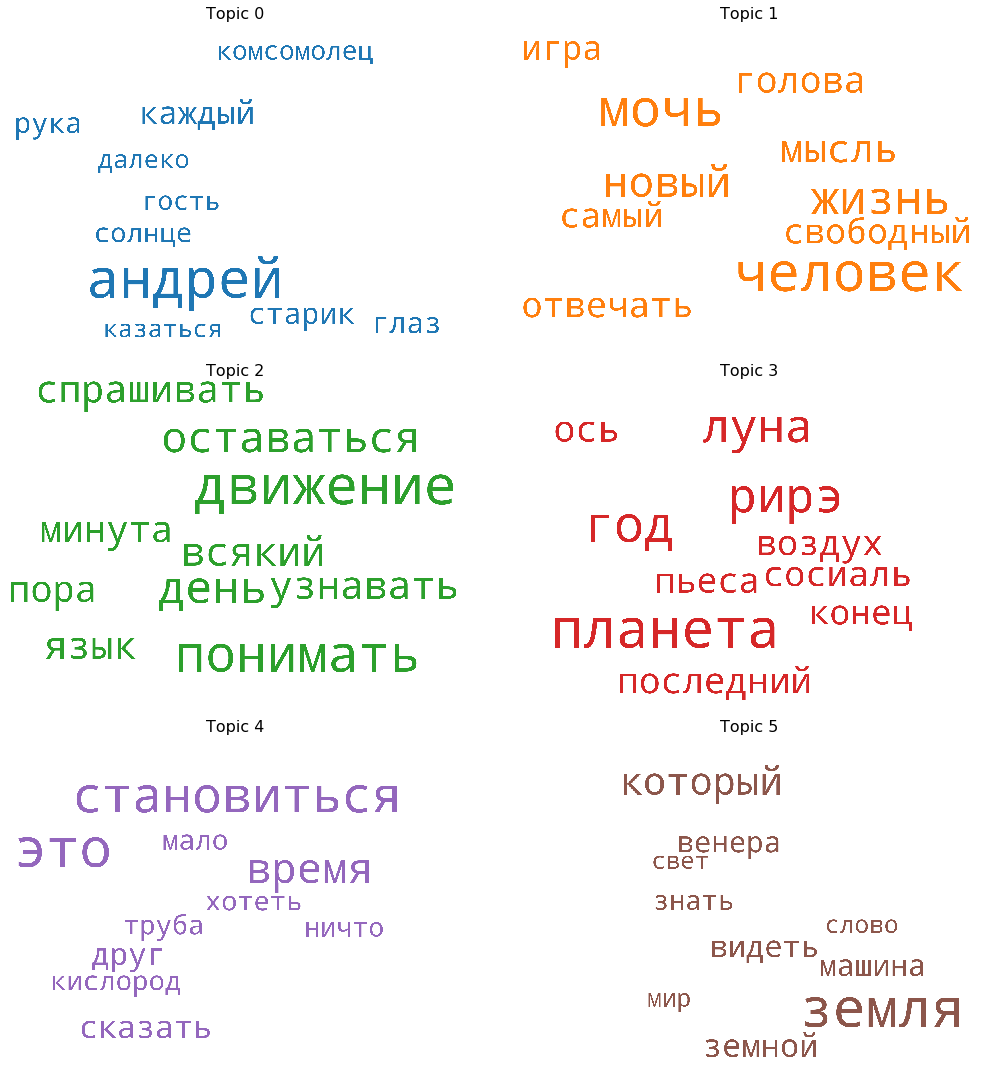

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Граф совместной встречаемости героев

Здесь нам понадобится библиотека для извлечения именованных сущностей и библиотека для работы с графами

In [9]:
from natasha.extractors import NamesExtractor
import networkx as nx
from collections import defaultdict

Для этой задачи мы можем брать не лемматизированный текст, потому что natasha умеет выдавать имена в именительном падаже + они в обычнлм тексте даже лучше будут рабоать

In [10]:
FILE = 'Dostoevsky_PrestuplenieINakazanie.txt'
with open(FILE) as f:
    corpus = f.read()

In [11]:
ne = NamesExtractor()

In [12]:
%%time
res = ne(corpus)

CPU times: user 1min 37s, sys: 1.31 s, total: 1min 39s
Wall time: 1min 39s


Теперь пройдемся по результатам и добавим в словарь информацию о том, сколько раз эти герои встречались на расстоянии не больше X (в символах)

1. Х = 100
2. Используем специальный словарь, который имеет значение по умолчанию 0, чтобы когда какая-то пара еще не встречалась, мы не получали ошибку KeyError и могли просто прибавлять единицу
3. Чтобы пары (A, B) и (B, A) не дублировали друг друга (нам важна пара, а не порядок), ключ в словаре формаруется в алфавитном порядке
4. Значение имени мы собираем по частям (имя + отчество + фамилия)

У нас есть еще проблемы с лемматизацией имен, поэтому сделаем преобразование для ошибок

In [13]:
name_mapping = {
    'зосим': 'зосимов',
    'раскольник': 'раскольников',
    'родион': 'раскольников',
    'родион  романыч': 'раскольников',
    'мармедладова': 'сонечка  мармеладова',
    'соня': 'сонечка  мармеладова',
    'сонечка': 'сонечка  мармеладова',
    'мармеладовая': 'сонечка  мармеладова',
    'дун': 'дуня',
    'родя': 'раскольников',
}

In [14]:
max_dist = 100
all_pairs = defaultdict(int)

for idx, name in enumerate(res[1:]):
    prev = res[idx-1]
    curr = name
    end = curr.span[1]
    start = prev.span[0]
    value1 = f'{prev.fact.first or ""} {prev.fact.middle or ""} {prev.fact.last or ""}'.strip()
    value2 = f'{curr.fact.first or ""} {curr.fact.middle or ""} {curr.fact.last or ""}'.strip()
    value1 = name_mapping.get(value1) or value1
    value2 = name_mapping.get(value2) or value2
    if end - start <= max_dist:
        if value1 > value2:
            pair = (value2, value1)
        else:
            pair = (value1, value2)
        if pair[0] != pair[1]:
            all_pairs[pair] += 1

Чтобы потом делить связи на частотные и не очень, мы должны понять, какое максимальное значение совместной встречаемости, чтобы потом их нормализовать (линейно) в промежутке от 0 до 1

In [15]:
max_cnt = max(all_pairs[i] for i in all_pairs)

Добаляем наши связи в граф, нормализуя их по весу

In [16]:
G = nx.Graph()
for pair in all_pairs:
    n1, n2 = pair
    w = all_pairs[pair] / max_cnt
    G.add_edge(n1, n2, weight=w)

Делим на две группы: популярные и нет (чтобы потом по-разному отобразить на графике)

In [17]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


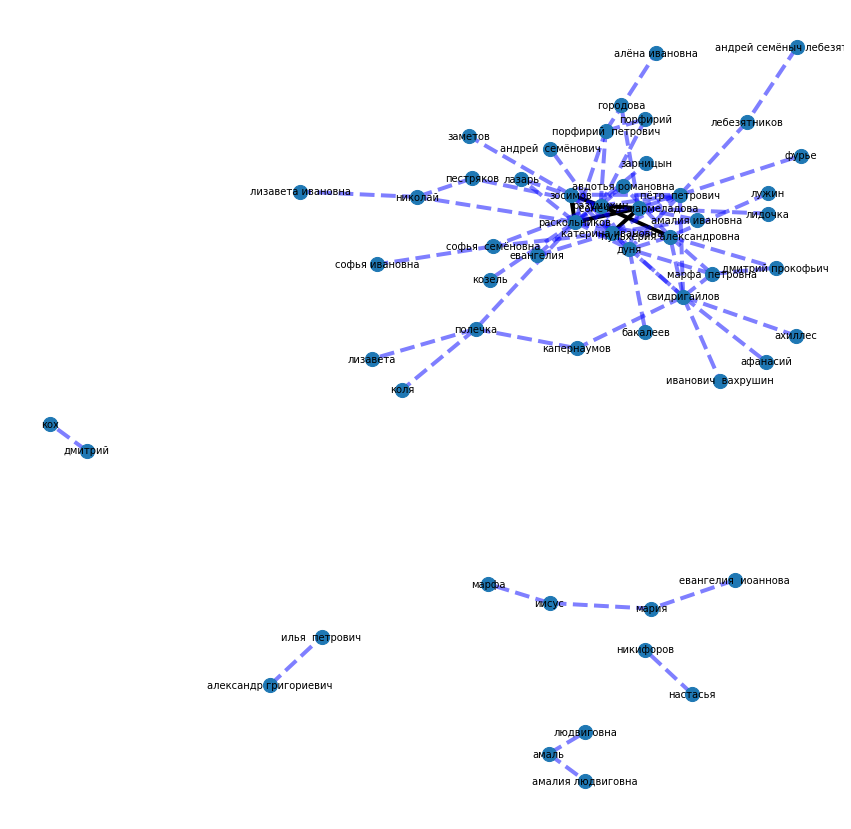

In [18]:
pos = nx.spring_layout(G)
plt.figure(figsize=(15, 15))

# рисуем вершины 
nx.draw_networkx_nodes(G, pos, node_size=200)
# рисуем популярные свзяи
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4)
# рисуем менее популярные свзяи
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=4, alpha=0.5, edge_color='b', style='dashed')
# подписи
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.show()

Давайте посмотрим на самые тесные связи, для этого возьмем подграф (вершины и ребра, которые входят в список ребер для сильных связей)

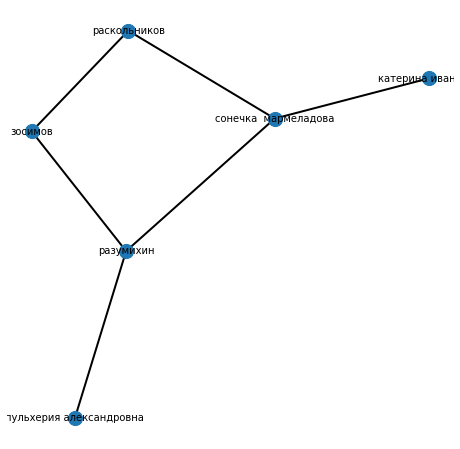

In [19]:
G2 = G.edge_subgraph(elarge)
pos = nx.spring_layout(G2)
plt.figure(figsize=(8, 8))

# рисуем вершины 
nx.draw_networkx_nodes(G2, pos, node_size=200)

# рисуем популярные свзяи
nx.draw_networkx_edges(G2, pos, edgelist=elarge, width=2)


# подписи
nx.draw_networkx_labels(G2, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.show()